<h1> The travelling salesman problem and simulated annealing</h1>

The travelling salesman problem is a combinatorial optimization problem. Wikipedia has a decent statement of the problem: 
<ul><li>"Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?".</li></ul>

So, let's suppose we want to go on vacation in Italy and visit some of its cities. Suppose these cities are the ones represented with red dots in the following map:

<img src="../IMAGES/Italy_simann.png",width=256,height=256>

Now we want to find the best path between these cities, with "the best" meaning the shortest one (taking planes). You realize we have many possible paths connecting all these cities (the number of paths grows factorially with the number of cities), and so we need some efficient way to explore the configuration space (the space of all the possible paths).

There's a lot of approaches that one can use to solve this problem (more or less efficiently, see <a href=''>https://en.wikipedia.org/wiki/Travelling_salesman_problem</a>). Here I will focus on <i>simulated annealing</i>. The algorithm is inspired by physical systems, where the crystalline structure of a block of material can be manipulated by heating and successive controlled cooling of the system. The crystalline structure of a material affects its internal energy, and so using annealing, one can drive the energy of the system to a minimum.  

<h3> Simulated annealing </h3>

In particular, I will use a stochastic approach, where we randomly move between states of the configuration space with a probability proportional to a Boltzmann factor $e^{-1/T_k}$, where $T_k$ is the "temperature" of the system after $k$ iterations performed by the algorithm. Let's call $\{c_i\}_{i=1,...,N}$ the set of N cities, and $s_{ij}$ the segment between city $c_i$ and city $c_j$. The steps one has to follow are very simple:

<ul>
<li>Randomly connect all the cities and calculate the total length of the path $L_0$ obtained in this way as:
\begin{align}
L_0 = \sum_{j>i=1}^N s_{ij} 
\end{align}
</li>
</ul>

For $k=1$ until convergence, or a finite amount of iterations, perform the following steps:

<ul>
<li>Change the path by, for example, switching two of the cities in the path, and calculate the new length of the path $L_k$.</li>
</ul>

<ul>
<li>If $L_k<L_{k-1}$ then accept the new path as the best solution. If $L_k>L_{k-1}$, accept $L_k$ as new path with probability proportional to $e^{-\Delta L/T_k}$, where
</li>
</ul>

\begin{align}
\Delta L = L_k - L_{k-1}
\end{align}


In order to simulate annealing, the temperature $T_k$ must decrease with increasing $k$. For example, one can define 

\begin{align}
T_k = c^kT_0,
\end{align}

where $c$ is a constant which regulates the change in temperature at each step, <i>e. g.</i>, $c=0.999$ and $T_0$ is the initial temperature.

The first iterative step described above has the effect of driving the system towards the shortest path (minimization of the length of the path), while the second step allows for jumps to worse solutions (prevents getting stuck in local minima), with a probability which decreases as the system cools down. This allows for the exploration of large areas of the configuration space at higher temperatures, but lets the system reach a stable state as the temperature decreases. 

For example, the length of the best path as a function of the temperature would look like this:

<img src="../IMAGES/annealing_temperature.png",width=1200,height=1200>

The above plot has been obtained by simulating the coordinates of 30 random points and running simulated annealing for 3 millions iterations. Each point on the graph corresponds to a path of length $L$. At the beginning, when the temperature is large, we are allowed to move almost freely in the configurations space by jumping from good to bad (and vice versa) configurations. Overall we move closer to the minimum in the configurations space since. As the temperature decreases, the movements are limited and we can see that the curve becomes less noisy (jumps to very bad solutions are strongly suppressed as the system cools down). Finally, when the temperature is very low, almost all the proposed moves are rejected and the system is stuck in the minimum (hopefully the global one!). 

<h3> Python implementation</h3>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

# Read and transform coordinates from file
def read_map(file_name):
    df = pd.read_csv(file_name)
    lon = []; lat = []
    for i in range(len(df)):
        deg = df.loc[i,'Lon'] - df.loc[i,'Lon'] % 1
        mins = 100.0*(df.loc[i,'Lon'] - deg)
        lon.append(deg + mins / 60.0)
        deg = df.loc[i,'Lat'] - df.loc[i,'Lat'] % 1
        mins = 100.0*(df.loc[i,'Lat'] - deg)
        lat.append(deg + mins / 60.0)
    return df, lon, lat

# Print map of cities function
def print_map(lon,lat,s=[]):
    fig, ax = plt.subplots(figsize=(10,7))
    m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=10.8, lon_0=12.37,
            llcrnrlon=6.59, llcrnrlat= 36.42, urcrnrlon=18.96, urcrnrlat=47.22)
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color='#f2f2f2',lake_color='#46bcec')
    m.drawcoastlines()
    for i in range(len(df)):
        x, y = m(lon[i],lat[i])
        m.plot(x, y, 'o', markersize=8, color='red', alpha=0.8)
    x, y = m(lon[s],lat[s])
    m.plot(x,y,lw=2.0,alpha=1.0)
    plt.show()
    return

# Calculate length of a path
def get_distance(x,y,s,N):
    l = 0.0
    for i in range(N):
        l += np.sqrt((x[s[i]] - x[s[i+1]])**2 + (y[s[i]] - y[s[i+1]])**2)
    return l

def anneal(x, y, s, T0=1.0, iter_max=10000, verbose=True):
    # Counters to keep track of accepted/rejected moves and path length
    acc = 0        
    rej = 0
    N = len(x)
    l = get_distance(x,y,s,N)
    if verbose:
        print('Initial guess length: %7.4f' % l)
    l_arr = [l]
    # Initiate iterative steps
    T = T0
    if verbose:
        print('Initial temperature: %7.4f' % T0)
    for i in range(1,iter_max+1):
        # Annealing (reduce temperature, cool down with steps)
        # Here we decrease the temperature every 100 steps
        if i % 100 == 0:
            T = 0.999 * T
        # Generate two random indices and switch them (switch cities)
        j,k = np.random.randint(low=1,high=N,size=2)
        s_new = np.copy(s)
        s_new[j] = s[k]
        s_new[k] = s[j]
        # Calculate length of new state (path)
        l_new = get_distance(x,y,s_new,N)
        delta_l = l_new - l
        # Accept the move if new path is shorter than previous one
        if delta_l <= 0.0:
            s = np.copy(s_new)
            l = l_new
            acc += 1
        # If new path is larger than previous, accept the move with probability
        # proportional to the Boltzmann factor
        elif delta_l > 0.0:
            u = np.random.uniform()
            if u < np.exp( - delta_l / T):
                s = np.copy(s_new)
                l = l_new
                acc += 1
            else:
                rej += 1
        if i % 100 == 0:
            l_arr.append(l)
        
    return s, l_arr, T, acc, rej

In [2]:
# Generate data (travelling salesman problem)
df, lon, lat = read_map(file_name='../DATASETS/italy_cities.csv')
N = len(df)
x = np.array(lon)
y = np.array(lat)

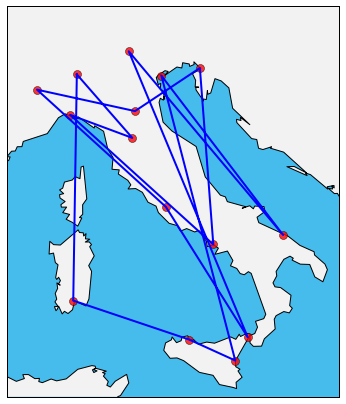

Length of initial guess: 76.9932281606


In [3]:
# Initialize state (path) and append as last the first
s = np.random.choice(N, size=N, replace=False)
s = np.append(s,s[0])
# Print map with the initial (random) path
print_map(x,y,s)
# Calculate length of the initial path
l = get_distance(x,y,s,N)
print('Length of initial guess:',l)

Initial guess length: 76.9932
Initial temperature:  1.0000
Accepted moves: 21065
Rejected moves: 178935
Final temperature:  0.1352
Final length after optimization: 34.8139


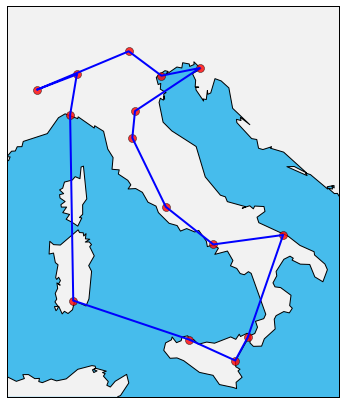

In [4]:
# Set parameters
iter_max = 200000 # Number of iterations
T = 1.0           # Initial temperature
# Simulate annealing
s, l_arr, T, accepted, rejected = anneal(x, y, s, T0=T, iter_max=iter_max)
print('Accepted moves: %d' % accepted)
print('Rejected moves: %d' % rejected)
print('Final temperature: %7.4f' % T)
print('Final length after optimization: %7.4f' % l_arr[-1])
# Print map with final shortest path
print_map(x,y,s)

Although in principle simulated annealing helps in avoiding local minima in the configurations space, it might still happen the final optimal result we find is a state in a local minimum. This is the case, for example, in the above plot. The path in the upper left corner of the map is clearly not the optimal one. One way to overcome this problem is to perform annealing multiple times by starting with a different initial guess each time. 

Length of the optimal path: 33.5846


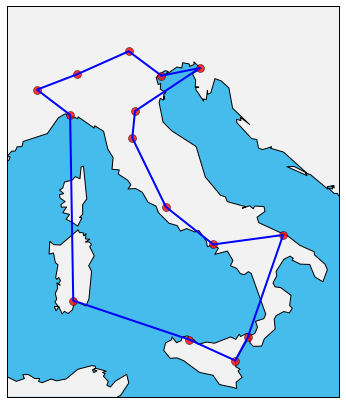

In [5]:
# Here we perform simulated annealing 10 times and select as optimal solution
# the one which gives the lowest path
s_best = None
l_best = None
for i in range(10):
    s = np.random.choice(N, size=N, replace=False)
    s = np.append(s,s[0])
    if s_best is None:
        s_best = np.copy(s)
    if l_best is None:
        l_best = get_distance(x,y,s,N)
    iter_max = 200000 # Number of iterations
    T = 1.0           # Initial temperature
    # Optimize with annealing
    s, l_arr, T, accepted, rejected = anneal(x, y, s, T0=T, iter_max=iter_max, verbose=False)
    # Check if this solution is better than the previous one
    if l_arr[-1] < l_best:
        l_best = l_arr[-1]
        s_best = np.copy(s)
print('Length of the optimal path: %7.4f' % l_best)
# Print map with final shortest path
print_map(x,y,s_best)

By annealing multiple times (starting from different random configurations each time), we keep track of the best (shortest) path and we can avoid local minima in the configuration space.